In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

In [6]:
data = pd.read_csv('dataset_sdn.csv')

In [7]:
data.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [8]:
# 0 is benign, 1 is malicious
data.label.unique()

array([0, 1])

In [9]:
data.label.value_counts()

label
0    63561
1    40784
Name: count, dtype: int64

<Axes: ylabel='count'>

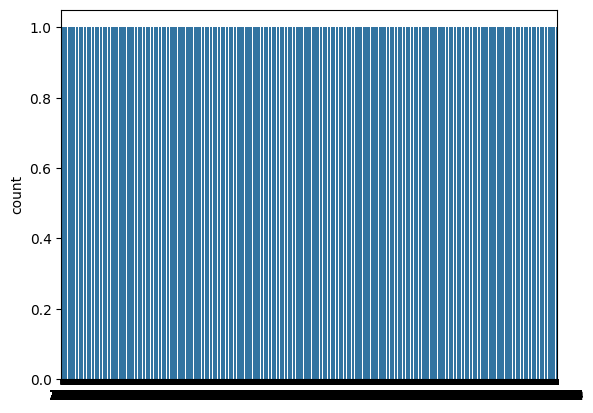

In [10]:
# label distribution
label_dict = dict(data.label.value_counts())
sns.countplot(data.label)

In [11]:
df1 = data.copy() # Keep original
df2 = data.copy() # Smote

In [12]:
def process_col(df):
    drop_cols = ['dt', 'src', 'dst', 'switch']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    obj_cols = df.select_dtypes(include=['object']).columns
    if len(obj_cols) > 0:
        df[obj_cols] = df[obj_cols].fillna(df[obj_cols].mode().iloc[0])

    if 'dur' in df.columns and 'dur_nsec' in df.columns:
        df['duration_sec'] = df['dur'] + df['dur_nsec'] / 1e9
    elif 'dur' in df.columns:
        df['duration_sec'] = df['dur']
    else:
        df['duration_sec'] = 0

    num_cols = [
        'pktcount', 'bytecount', 'duration_sec', 'flows', 'packetins', 
        'pktperflow', 'byteperflow', 'pktrate', 'tx_bytes', 'rx_bytes', 
        'tx_kbps', 'rx_kbps', 'tot_kbps', 'port_no'
    ]
    num_cols = [c for c in num_cols if c in df.columns]

    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    return df

df1= process_col(df1)
df2 = process_col(df2)


In [13]:
#### Let's support which columns NUMERIC and which is OBJECT
def show_feature_type(df):
    df.columns = df.columns.str.strip().str.lower()
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    object_df = df.select_dtypes(include=['object'])
    numeric_cols = numeric_df.columns
    object_cols = object_df.columns
    print('Numeric Columns: ')
    print(numeric_cols, '\n')
    print('Object Columns: ')
    print(object_cols, '\n')
    print('Number of Numeric Features: ', len(numeric_cols))
    print('Number of Object Features: ', len(object_cols))

print('############## OG ##############')
show_feature_type(df1)
print('\n')
print('############## SMOTE ##############')
show_feature_type(df2)

############## OG ##############
Numeric Columns: 
Index(['pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
       'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'pairflow',
       'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps',
       'label', 'duration_sec'],
      dtype='object') 

Object Columns: 
Index(['protocol'], dtype='object') 

Number of Numeric Features:  19
Number of Object Features:  1


############## SMOTE ##############
Numeric Columns: 
Index(['pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
       'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'pairflow',
       'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps',
       'label', 'duration_sec'],
      dtype='object') 

Object Columns: 
Index(['protocol'], dtype='object') 

Number of Numeric Features:  19
Number of Object Features:  1


In [14]:
print(df1.isna().sum())
print(df2.isna().sum())

pktcount        0
bytecount       0
dur             0
dur_nsec        0
tot_dur         0
flows           0
packetins       0
pktperflow      0
byteperflow     0
pktrate         0
pairflow        0
protocol        0
port_no         0
tx_bytes        0
rx_bytes        0
tx_kbps         0
rx_kbps         0
tot_kbps        0
label           0
duration_sec    0
dtype: int64
pktcount        0
bytecount       0
dur             0
dur_nsec        0
tot_dur         0
flows           0
packetins       0
pktperflow      0
byteperflow     0
pktrate         0
pairflow        0
protocol        0
port_no         0
tx_bytes        0
rx_bytes        0
tx_kbps         0
rx_kbps         0
tot_kbps        0
label           0
duration_sec    0
dtype: int64


In [15]:
print('############## OG ##############')
df1.isna().sum().sum()  

print(df1['label'].unique())

print(df1.columns)

print('\n')

print('############## SMOTE ##############')
df2.isna().sum().sum()  

print(df2['label'].unique())

print(df2.columns)



############## OG ##############
[0 1]
Index(['pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
       'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'pairflow',
       'protocol', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps', 'label', 'duration_sec'],
      dtype='object')


############## SMOTE ##############
[0 1]
Index(['pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
       'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'pairflow',
       'protocol', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps', 'label', 'duration_sec'],
      dtype='object')


In [16]:
df1.head()

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,pairflow,protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,duration_sec
0,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,3,143928631,3917,0,0.0,0.0,0,100.716
1,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP,4,3842,3520,0,0.0,0.0,0,280.734
2,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0.0,0,200.744
3,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,2,3688,1492,0,0.0,0.0,0,200.744
4,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3,3413,3665,0,0.0,0.0,0,200.744


In [17]:
df2.head()

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,pairflow,protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,duration_sec
0,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,3,143928631,3917,0,0.0,0.0,0,100.716
1,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP,4,3842,3520,0,0.0,0.0,0,280.734
2,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0.0,0,200.744
3,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,2,3688,1492,0,0.0,0.0,0,200.744
4,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3,3413,3665,0,0.0,0.0,0,200.744


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def normalization(df):
    """
    Tiền xử lý dataset DDoS SDN:
    - Chuyển các cột số sang numeric
    - Loại bỏ giá trị invalid
    - Encode cột categorical
    - Tạo thêm feature hữu ích
    - Không loại bỏ outlier quan trọng cho class malicious
    """
    
    # -----------------------------
    # 1. Chuyển kiểu dữ liệu
    # -----------------------------
    df['duration_sec'] = pd.to_numeric(df['duration_sec'], errors='coerce')
    
    # port_no có thể bỏ hoặc giữ nếu muốn phân tích thống kê, không dùng làm feature ML
    if 'port_no' in df.columns:
        df['port_no'] = pd.to_numeric(df['port_no'], errors='coerce')

    # -----------------------------
    # 2. Loại bỏ giá trị invalid
    # -----------------------------
    df = df[df['pktcount'] >= 0]
    df = df[df['bytecount'] >= 0]
    df = df[df['dur'] >= 0]  # đảm bảo duration không âm

    # -----------------------------
    # 3. Label encoding cột categorical
    # -----------------------------
    if 'protocol' in df.columns:
        le = LabelEncoder()
        df['protocol'] = le.fit_transform(df['protocol'])
        protocol_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print("Protocol mapping:", protocol_mapping)

    # -----------------------------
    # 4. Feature engineering
    # -----------------------------
    # Tốc độ gửi gói
    df['pkt_per_sec'] = df['pktcount'] / (df['dur'] + 1e-5)
    
    # Số byte trung bình trên mỗi gói
    df['byte_per_pkt'] = df['bytecount'] / (df['pktcount'] + 1e-5)
    
    # Có thể thêm các feature khác nếu cần, ví dụ:
    # df['flows_per_sec'] = df['flows'] / (df['dur'] + 1e-5)

    # -----------------------------
    # 5. Loại bỏ NaN sau conversion
    # -----------------------------
    df = df.dropna().reset_index(drop=True)

    return df

In [19]:
df1 = normalization(df1)

Protocol mapping: {'ICMP': np.int64(0), 'TCP': np.int64(1), 'UDP': np.int64(2)}


In [20]:
df2 = normalization(df2)

Protocol mapping: {'ICMP': np.int64(0), 'TCP': np.int64(1), 'UDP': np.int64(2)}


In [21]:
def split_dataset(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    drop_cols = ['dt', 'src', 'dst', 'switch']
    numeric_cols = [c for c in numeric_cols if c not in drop_cols]
    
    X = df[numeric_cols]
    y = df['label']
  
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    return X_train, X_test, y_train, y_test


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

def process_data(X_train, X_test, y_train, y_test):
    # Apply SMOTE on training data only
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Feature selection on resampled train data
    selector = SelectKBest(f_classif, k=10)
    X_train_selected = selector.fit_transform(X_train_res, y_train_res)
    X_test_selected = selector.transform(X_test)  # use same features
    
    # Scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    return X_train_scaled, X_test_scaled, y_train_res, y_test


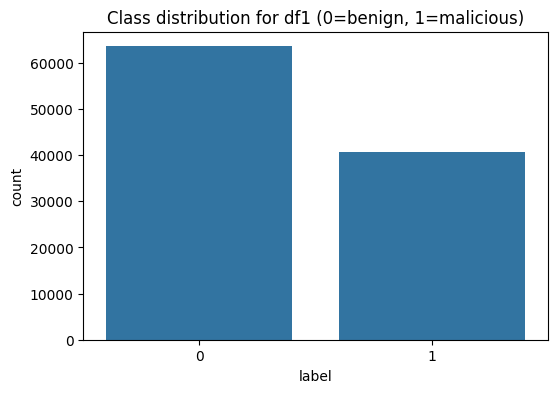

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df1)
plt.title("Class distribution for df1 (0=benign, 1=malicious)")
plt.show()


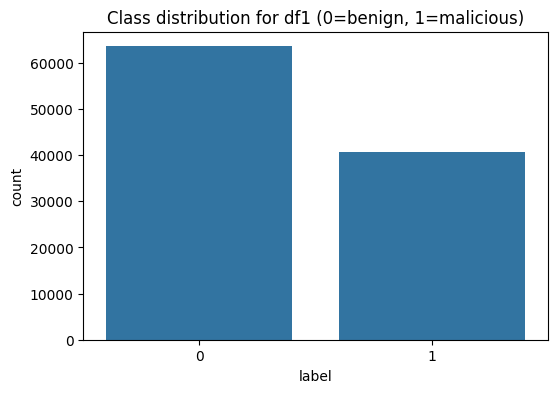

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df2)
plt.title("Class distribution for df1 (0=benign, 1=malicious)")
plt.show()


In [ ]:
########################### TRAIN ###########################
X_train1, X_test1, y_train1, y_test1 = split_dataset(df1)
X_train2, X_test2, y_train2, y_test2 = split_dataset(df2)

In [26]:
X_train2_scaled, X_test2_scaled, y_train2_res, y_test2 = process_data(X_train2, X_test2, y_train2, y_test2)

/Users/tiendat.nguyen.int/Documents/THESIS/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [27]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    IsolationForest
)

from sklearn import (
    metrics,
    preprocessing,
    metrics,
    svm
)

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler
)

from sklearn.feature_selection import (
    SelectKBest, 
    f_classif
)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import (
    layers, 
    models, 
    callbacks
)

from xgboost import XGBClassifier

In [28]:
class Model:
    def __init__(self, X, y):
        self.data = X
        self.labels = y
        self.results = {}

        X_scaled = StandardScaler().fit_transform(X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_scaled, y, random_state=42, test_size=0.3, stratify=y
        )

    def LogisticRegression(self):
        print("\n=== Logistic Regression ===")
        solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        best_accuracy = 0
        best_solver = ''
        start_time = time.time()

        for solver in solvers:
            try:
                model = LogisticRegression(C=0.03, solver=solver, max_iter=1000)
                model.fit(self.X_train, self.y_train)
                y_pred = model.predict(self.X_test)
                acc = accuracy_score(self.y_test, y_pred)
                print(f"Solver: {solver}, Accuracy: {acc:.4f}")
                if acc > best_accuracy:
                    best_accuracy = acc
                    best_solver = solver
            except Exception as e:
                print(f"Solver {solver} failed: {e}")

        print(f"\nBest Solver: {best_solver} with Accuracy: {best_accuracy:.4f}")
        model = LogisticRegression(C=0.03, solver=best_solver, max_iter=1000)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["Logistic Regression"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def SupportVectorMachine(self):
        print("\n=== SVM ===")
        kernels = ['linear', 'poly', 'rbf', 'sigmoid']
        best_accuracy = 0
        best_kernel = ''
        start_time = time.time()

        for kernel in kernels:
            model = svm.SVC(kernel=kernel)
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            acc = accuracy_score(self.y_test, y_pred)
            print(f"Kernel: {kernel}, Accuracy: {acc:.4f}")
            if acc > best_accuracy:
                best_accuracy = acc
                best_kernel = kernel

        print(f"\nBest Kernel: {best_kernel} with Accuracy: {best_accuracy:.4f}")
        model = svm.SVC(kernel=best_kernel)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["SVM"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def KNearestNeighbor(self):
        print("\n=== K-Nearest Neighbors ===")
        start_time = time.time()
        accuracies = []
        Ks = 12

        for k in range(1, Ks):
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            acc = accuracy_score(self.y_test, y_pred)
            accuracies.append(acc)

        best_k = np.argmax(accuracies) + 1
        print(f"Best K: {best_k} with Accuracy: {accuracies[best_k-1]:.4f}")

        model = KNeighborsClassifier(n_neighbors=best_k)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["Kth Nearest"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def DecisionTree(self):
        print("\n=== Decision Tree ===")
        start_time = time.time()

        tree = DecisionTreeClassifier()
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': list(range(2, 11)),
            'max_leaf_nodes': list(range(2, 12))
        }

        grid = GridSearchCV(tree, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=0)
        grid.fit(self.X_train, self.y_train)

        print("Best Params:", grid.best_params_)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(self.X_test)

        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["Decision Tree"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def RandomForest(self):
        print("\n=== Random Forest ===")
        start_time = time.time()

        model = RandomForestClassifier(
            criterion='gini',
            n_estimators=500,
            min_samples_split=10,
            max_features='sqrt',
            oob_score=True,
            random_state=1,
            n_jobs=-1
        )
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)

        print(f"Accuracy: {accuracy_score(self.y_test, y_pred):.4f}")
        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["Random Forest"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def autoencoder_iforest(self):
        print("\n=== AutoEncoder + Isolation Forest ===")
        start_time = time.time()

        input_dim = self.X_train.shape[1]
        encoding_dim = 32

        input_layer = layers.Input(shape=(input_dim,))
        encoded = layers.Dense(64, activation='relu')(input_layer)
        encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

        autoencoder = models.Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(self.X_train, self.X_train,
                        epochs=50,
                        batch_size=32,
                        shuffle=True,
                        validation_data=(self.X_test, self.X_test),
                        verbose=0)

        encoder = models.Model(input_layer, encoded)
        X_train_encoded = encoder.predict(self.X_train)
        X_test_encoded = encoder.predict(self.X_test)

        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        iso_forest.fit(X_train_encoded)
        y_pred = iso_forest.predict(X_test_encoded)
        y_pred_binary = (y_pred == -1).astype(int)

        print(classification_report(self.y_test, y_pred_binary))
        auc = metrics.roc_auc_score(self.y_test, iso_forest.decision_function(X_test_encoded))
        print(f"AUC-ROC: {auc:.4f}")
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["Autoencoder + Isolation Forest"] = {
            "accuracy": accuracy_score(self.y_test, y_pred_binary),
            "precision": precision_score(self.y_test, y_pred_binary),
            "recall": recall_score(self.y_test, y_pred_binary),
            "f1": f1_score(self.y_test, y_pred_binary)
        }

        

    def xgboost(self):
        print("\n=== XGBoost ===")
        start_time = time.time()
        model = XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        y_proba = model.predict_proba(self.X_test)[:, 1]

        # Classification Report
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred))

        # ROC AUC
        roc_auc = roc_auc_score(self.y_test, y_proba)
        print("AUC-ROC:", round(roc_auc, 4))

        # Confusion Matrix
        # cm = confusion_matrix(self.y_test, y_pred)
        # plt.figure(figsize=(6, 4))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_proba)
        # plt.figure()
        # plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        # plt.plot([0, 1], [0, 1], 'k--')
        # plt.xlabel("False Positive Rate")
        # plt.ylabel("True Positive Rate")
        # plt.title("ROC Curve")
        # plt.legend()
        # plt.grid()
        # plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_proba)
        pr_auc = auc(recall, precision)
        # plt.figure()
        # plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})', color='purple')
        # plt.xlabel("Recall")
        # plt.ylabel("Precision")
        # plt.title("Precision-Recall Curve")
        # plt.legend()
        # plt.grid()
        # plt.show()

        #return model

        print(f"Accuracy: {accuracy_score(self.y_test, y_pred):.4f}")
        print(classification_report(self.y_test, y_pred))
        print("--- %s seconds ---" % (time.time() - start_time))

        self.results["XGBoost"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred)
        }

    def MLP(self, epochs=50, batch_size=64):
        print("\n=== MLP (Dense) ===")
        start_time = time.time()

        input_dim = self.X_train.shape[1]
        model = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(self.X_train, self.y_train, validation_split=0.1,
                            epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)

        y_proba = model.predict(self.X_test).ravel()
        y_pred = (y_proba > 0.5).astype(int)

        print(classification_report(self.y_test, y_pred))
        self.results["MLP"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred, zero_division=0),
            "recall": recall_score(self.y_test, y_pred, zero_division=0),
            "f1": f1_score(self.y_test, y_pred, zero_division=0)
        }
        print("--- %s seconds ---" % (time.time() - start_time))
        return model, history

    def LSTM(self, epochs=50, batch_size=64, timesteps=1):
        """
        LSTM expects 3D input: (samples, timesteps, features).
        If your data is NOT windowed, use timesteps=1 (default). For sequence data,
        prepare X as windows and set timesteps accordingly.
        """
        print("\n=== LSTM ===")
        start_time = time.time()

        n_features = self.X_train.shape[1]
        # reshape to (samples, timesteps, features)
        X_train_seq = self.X_train.reshape((self.X_train.shape[0], timesteps, n_features))
        X_test_seq = self.X_test.reshape((self.X_test.shape[0], timesteps, n_features))

        model = models.Sequential([
            layers.Input(shape=(timesteps, n_features)),
            layers.LSTM(64, return_sequences=False),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(X_train_seq, self.y_train, validation_split=0.1, epochs=epochs,
                            batch_size=batch_size, callbacks=[es], verbose=0)

        y_proba = model.predict(X_test_seq).ravel()
        y_pred = (y_proba > 0.5).astype(int)

        print(classification_report(self.y_test, y_pred))
        self.results["LSTM"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred, zero_division=0),
            "recall": recall_score(self.y_test, y_pred, zero_division=0),
            "f1": f1_score(self.y_test, y_pred, zero_division=0)
        }
        print("--- %s seconds ---" % (time.time() - start_time))
        return model, history

    def GRU(self, epochs=50, batch_size=64, timesteps=1):
        """
        Similar to LSTM but using GRU layers.
        """
        print("\n=== GRU ===")
        start_time = time.time()

        n_features = self.X_train.shape[1]
        X_train_seq = self.X_train.reshape((self.X_train.shape[0], timesteps, n_features))
        X_test_seq = self.X_test.reshape((self.X_test.shape[0], timesteps, n_features))

        model = models.Sequential([
            layers.Input(shape=(timesteps, n_features)),
            layers.GRU(64, return_sequences=False),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(X_train_seq, self.y_train, validation_split=0.1, epochs=epochs,
                            batch_size=batch_size, callbacks=[es], verbose=0)

        y_proba = model.predict(X_test_seq).ravel()
        y_pred = (y_proba > 0.5).astype(int)

        print(classification_report(self.y_test, y_pred))
        self.results["GRU"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred, zero_division=0),
            "recall": recall_score(self.y_test, y_pred, zero_division=0),
            "f1": f1_score(self.y_test, y_pred, zero_division=0)
        }
        print("--- %s seconds ---" % (time.time() - start_time))
        return model, history

    def Conv1D(self, epochs=50, batch_size=64):
        """
        1D-CNN for tabular data: we reshape to (samples, features, 1) and apply Conv1D.
        """
        print("\n=== 1D-CNN ===")
        start_time = time.time()

        n_features = self.X_train.shape[1]
        # reshape to (samples, timesteps=n_features, channels=1)
        X_train_cnn = self.X_train.reshape((self.X_train.shape[0], n_features, 1))
        X_test_cnn = self.X_test.reshape((self.X_test.shape[0], n_features, 1))

        model = models.Sequential([
            layers.Input(shape=(n_features, 1)),
            layers.Conv1D(64, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(32, kernel_size=3, activation='relu'),
            layers.GlobalMaxPooling1D(),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(X_train_cnn, self.y_train, validation_split=0.1,
                            epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)

        y_proba = model.predict(X_test_cnn).ravel()
        y_pred = (y_proba > 0.5).astype(int)

        print(classification_report(self.y_test, y_pred))
        self.results["1D-CNN"] = {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred, zero_division=0),
            "recall": recall_score(self.y_test, y_pred, zero_division=0),
            "f1": f1_score(self.y_test, y_pred, zero_division=0)
        }
        print("--- %s seconds ---" % (time.time() - start_time))
        return model, history

    def plot_results(self, metric="accuracy"):
        """
        Plots bar chart comparing models on a selected metric.
        Metric can be: 'accuracy', 'precision', 'recall', or 'f1'
        """
        if not self.results:
            print("No results to plot. Run some models first.")
            return
        
        valid_metrics = ["accuracy", "precision", "recall", "f1"]
        if metric not in valid_metrics:
            raise ValueError(f"Invalid metric. Choose from {valid_metrics}")

        model_names = list(self.results.keys())
        values = [self.results[model][metric] for model in model_names]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=model_names, y=values, palette="Set2")
        plt.title(f"Model Comparison on {metric.capitalize()}")
        plt.ylabel(metric.capitalize())
        plt.xlabel("Model")
        plt.ylim(0, 1.05)
        plt.xticks(rotation=30)
        for i, v in enumerate(values):
            plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()




In [29]:
X1 = df1.drop(['label'], axis=1)
y1 = df1.label

In [30]:
X2 = df2.drop(['label'], axis=1)
y2 = df2.label

In [31]:
X1 = pd.get_dummies(X1)
X2 = pd.get_dummies(X2)

In [33]:
model1 = Model(X1, y1)
model2 = Model(X2, y2)

In [34]:
model1.LogisticRegression()


=== Logistic Regression ===
Solver: newton-cg, Accuracy: 0.9069
Solver: lbfgs, Accuracy: 0.9069
Solver: liblinear, Accuracy: 0.9069
Solver: sag, Accuracy: 0.9069
Solver: saga, Accuracy: 0.9069

Best Solver: liblinear with Accuracy: 0.9069
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     19069
           1       0.89      0.87      0.88     12235

    accuracy                           0.91     31304
   macro avg       0.90      0.90      0.90     31304
weighted avg       0.91      0.91      0.91     31304

--- 2.3270959854125977 seconds ---


In [35]:
model2.LogisticRegression()


=== Logistic Regression ===
Solver: newton-cg, Accuracy: 0.9069
Solver: lbfgs, Accuracy: 0.9069
Solver: liblinear, Accuracy: 0.9069
Solver: sag, Accuracy: 0.9069
Solver: saga, Accuracy: 0.9069

Best Solver: liblinear with Accuracy: 0.9069
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     19069
           1       0.89      0.87      0.88     12235

    accuracy                           0.91     31304
   macro avg       0.90      0.90      0.90     31304
weighted avg       0.91      0.91      0.91     31304

--- 2.2804510593414307 seconds ---


In [36]:
model1.SupportVectorMachine()


=== SVM ===
Kernel: linear, Accuracy: 0.9098
Kernel: poly, Accuracy: 0.9641
Kernel: rbf, Accuracy: 0.9672
Kernel: sigmoid, Accuracy: 0.6554

Best Kernel: rbf with Accuracy: 0.9672
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     19069
           1       0.95      0.97      0.96     12235

    accuracy                           0.97     31304
   macro avg       0.96      0.97      0.97     31304
weighted avg       0.97      0.97      0.97     31304

--- 263.7650661468506 seconds ---


In [37]:
model2.SupportVectorMachine()


=== SVM ===
Kernel: linear, Accuracy: 0.9098
Kernel: poly, Accuracy: 0.9641
Kernel: rbf, Accuracy: 0.9672
Kernel: sigmoid, Accuracy: 0.6554

Best Kernel: rbf with Accuracy: 0.9672
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     19069
           1       0.95      0.97      0.96     12235

    accuracy                           0.97     31304
   macro avg       0.96      0.97      0.97     31304
weighted avg       0.97      0.97      0.97     31304

--- 268.13803267478943 seconds ---


In [38]:
model1.KNearestNeighbor()


=== K-Nearest Neighbors ===
Best K: 1 with Accuracy: 0.9810
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19069
           1       0.98      0.98      0.98     12235

    accuracy                           0.98     31304
   macro avg       0.98      0.98      0.98     31304
weighted avg       0.98      0.98      0.98     31304

--- 12.921324014663696 seconds ---


In [40]:
model2.KNearestNeighbor()


=== K-Nearest Neighbors ===
Best K: 1 with Accuracy: 0.9810
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19069
           1       0.98      0.98      0.98     12235

    accuracy                           0.98     31304
   macro avg       0.98      0.98      0.98     31304
weighted avg       0.98      0.98      0.98     31304

--- 12.256112813949585 seconds ---


In [41]:
model1.DecisionTree()


=== Decision Tree ===
Best Params: {'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 11}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19069
           1       0.98      0.99      0.98     12235

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

--- 17.31065607070923 seconds ---


In [42]:
model2.DecisionTree()


=== Decision Tree ===
Best Params: {'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 11}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19069
           1       0.98      0.99      0.98     12235

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

--- 13.985419034957886 seconds ---


In [43]:
model1.RandomForest()


=== Random Forest ===
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19069
           1       1.00      1.00      1.00     12235

    accuracy                           1.00     31304
   macro avg       1.00      1.00      1.00     31304
weighted avg       1.00      1.00      1.00     31304

--- 6.461575984954834 seconds ---


In [44]:
model2.RandomForest()


=== Random Forest ===
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19069
           1       1.00      1.00      1.00     12235

    accuracy                           1.00     31304
   macro avg       1.00      1.00      1.00     31304
weighted avg       1.00      1.00      1.00     31304

--- 6.364078998565674 seconds ---


In [45]:
model1.autoencoder_iforest()


=== AutoEncoder + Isolation Forest ===
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 1s 212us/step
979/979 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
              precision    recall  f1-score   support

           0       0.61      0.90      0.73     19069
           1       0.40      0.10      0.17     12235

    accuracy                           0.59     31304
   macro avg       0.50      0.50      0.45     31304
weighted avg       0.53      0.59      0.51     31304

AUC-ROC: 0.5528
--- 63.93573498725891 seconds ---


In [46]:
model2.autoencoder_iforest()


=== AutoEncoder + Isolation Forest ===
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 1s 214us/step
979/979 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
              precision    recall  f1-score   support

           0       0.62      0.91      0.73     19069
           1       0.45      0.12      0.18     12235

    accuracy                           0.60     31304
   macro avg       0.53      0.51      0.46     31304
weighted avg       0.55      0.60      0.52     31304

AUC-ROC: 0.5420
--- 62.668983936309814 seconds ---


In [47]:
model1.MLP()


=== MLP (Dense) ===
979/979 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19069
           1       0.98      1.00      0.99     12235

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

--- 31.202411890029907 seconds ---


(<Sequential name=sequential_1, built=True>,
 <keras.src.callbacks.history.History at 0x3f302ea20>)

In [48]:
model2.MLP()


=== MLP (Dense) ===
979/979 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19069
           1       0.99      0.99      0.99     12235

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

--- 31.6510488986969 seconds ---


(<Sequential name=sequential_2, built=True>,
 <keras.src.callbacks.history.History at 0x3f368ba40>)

In [49]:
model1.LSTM(timesteps=1)  


=== LSTM ===
979/979 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19069
           1       0.98      1.00      0.99     12235

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

--- 40.35140895843506 seconds ---


(<Sequential name=sequential_3, built=True>,
 <keras.src.callbacks.history.History at 0x3f2ef1ac0>)

In [50]:
model2.LSTM(timesteps=1)  


=== LSTM ===
979/979 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19069
           1       0.99      0.99      0.99     12235

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

--- 37.82391977310181 seconds ---


(<Sequential name=sequential_4, built=True>,
 <keras.src.callbacks.history.History at 0x3e782a8d0>)

In [51]:
model1.GRU(timesteps=1)


=== GRU ===
979/979 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19069
           1       0.98      0.99      0.99     12235

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

--- 26.379122972488403 seconds ---


(<Sequential name=sequential_5, built=True>,
 <keras.src.callbacks.history.History at 0x3e79b1e20>)

In [52]:
model2.GRU(timesteps=1)


=== GRU ===
979/979 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19069
           1       0.99      0.99      0.99     12235

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

--- 47.49668312072754 seconds ---


(<Sequential name=sequential_6, built=True>,
 <keras.src.callbacks.history.History at 0x3e7820590>)

In [53]:
model1.Conv1D()


=== 1D-CNN ===
979/979 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19069
           1       0.99      0.99      0.99     12235

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

--- 72.77912497520447 seconds ---


(<Sequential name=sequential_7, built=True>,
 <keras.src.callbacks.history.History at 0x3e789bad0>)

In [54]:
model2.Conv1D()


=== 1D-CNN ===
979/979 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19069
           1       0.98      1.00      0.99     12235

    accuracy                           0.99     31304
   macro avg       0.99      0.99      0.99     31304
weighted avg       0.99      0.99      0.99     31304

--- 52.91007924079895 seconds ---


(<Sequential name=sequential_8, built=True>,
 <keras.src.callbacks.history.History at 0x3e6d0e630>)

/var/folders/4z/8k6gwjfs0h7ctcg937lt487r0000gr/T/ipykernel_7100/2551329560.py:443: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=values, palette="Set2")


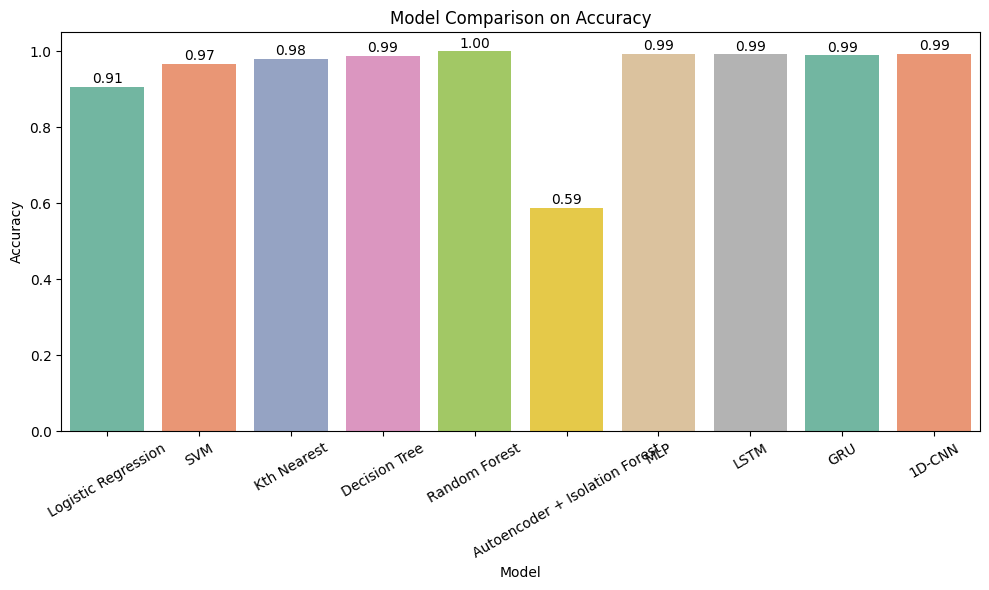

/var/folders/4z/8k6gwjfs0h7ctcg937lt487r0000gr/T/ipykernel_7100/2551329560.py:443: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=values, palette="Set2")


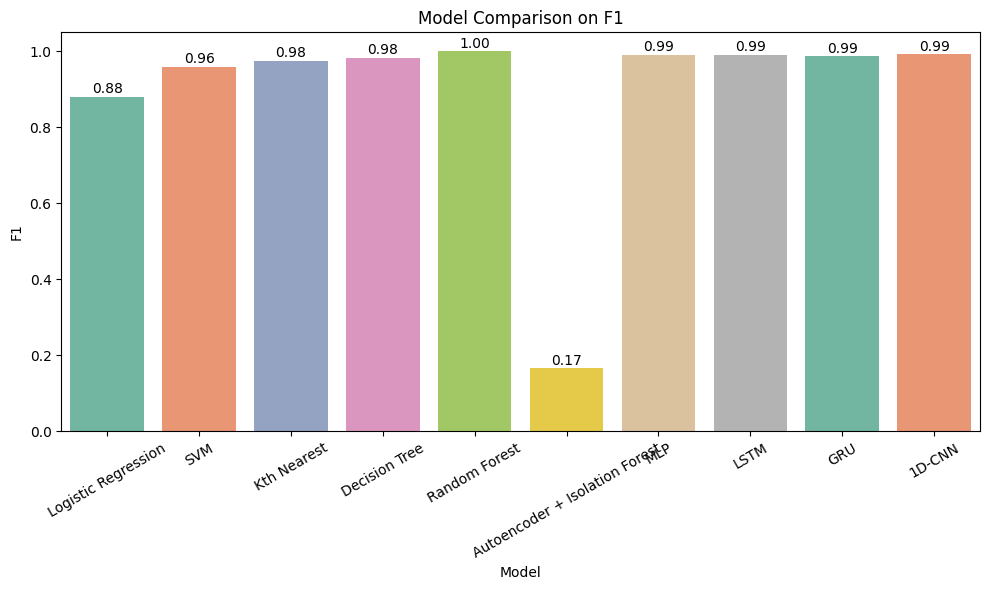

In [56]:
model1.plot_results("accuracy")
model1.plot_results("f1")

/var/folders/4z/8k6gwjfs0h7ctcg937lt487r0000gr/T/ipykernel_7100/2551329560.py:443: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=values, palette="Set2")


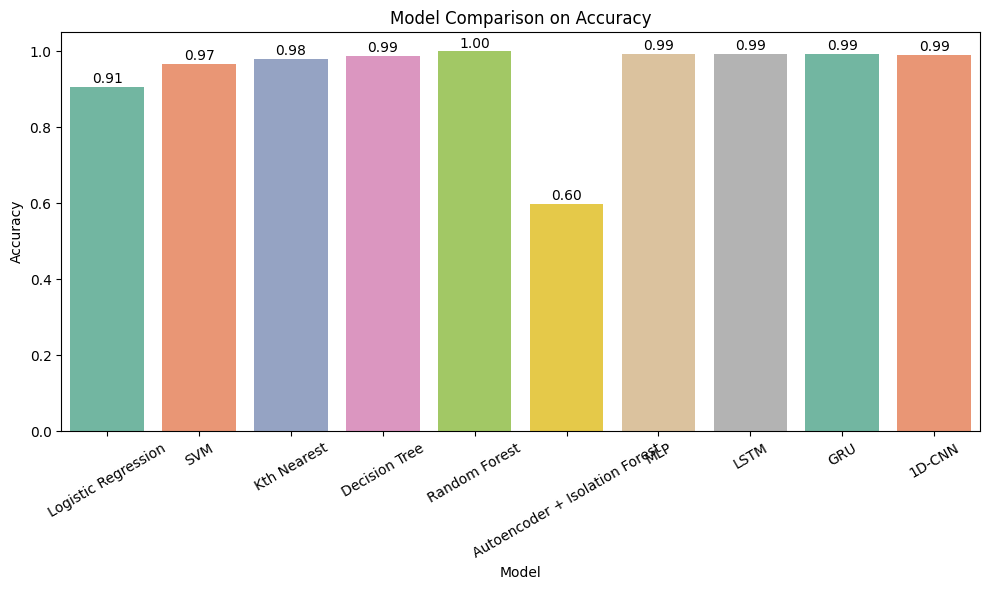

/var/folders/4z/8k6gwjfs0h7ctcg937lt487r0000gr/T/ipykernel_7100/2551329560.py:443: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=values, palette="Set2")


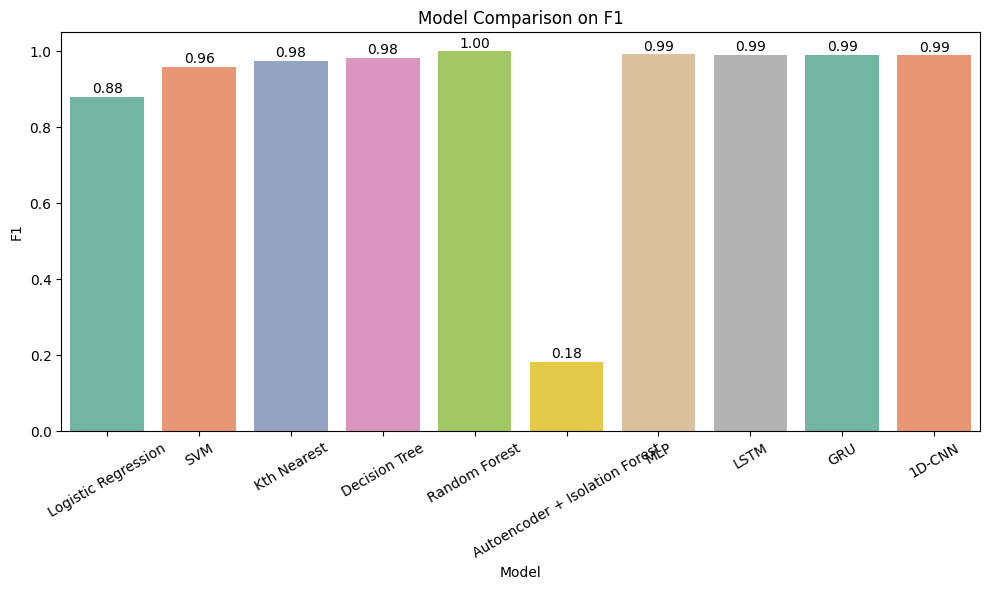

In [57]:
model2.plot_results("accuracy")
model2.plot_results("f1")